In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import matplotlib
import matplotlib.pyplot as plt
import time
import numpy as np
import query_db
import composite

In [24]:
SN_Array = composite.grab("SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN", multi_epoch = True, make_corr = False)

ERROR:  1998bu_19990126_0_2_00.dat None
ERROR:  2002bo_20020314_0_2_00.dat None
ERROR:  2002bo_20020403_0_2_00.dat None
ERROR:  2002bo_20020421_0_2_00.dat None
ERROR:  2002bo_20020518_0_2_00.dat None
ERROR:  2002bo_20020615_9394_16509_00.dat None
ERROR:  2003hv_20040901_51567_151964_00.dat None
ERROR:  sn2006oa-20061116-not.dat None
ERROR:  sn2006oa-20061122-not.dat None
ERROR:  sn2007jg-20070918-not.dat None
ERROR:  sn2011fe-20110826-snifs.dat None
ERROR:  sn2011fe-20110827-snifs.dat None
ERROR:  sn2011fe-20110828-snifs.dat None
ERROR:  sn2011fe-20110829-snifs.dat None
ERROR:  sn2011fe-20110830-snifs.dat None
ERROR:  sn2011fe-20110831-snifs.dat None
ERROR:  sn2011fe-20110901-snifs.dat None
ERROR:  sn2011fe-20110902-snifs.dat None
ERROR:  sn2011fe-20110903-snifs.dat None
ERROR:  sn2011fe-20110904-snifs.dat None
ERROR:  sn2011fe-20110905-snifs.dat None
ERROR:  sn2011fe-20110909-snifs.dat None
ERROR:  sn2011fe-20110910-snifs.dat None
ERROR:  sn2011fe-20110911-snifs.dat None
ERROR:  sn201

In [25]:
event_dict = {}
for i in range(len(SN_Array)):
    if event_dict.get(SN_Array[i].name) is None:
        event_dict[SN_Array[i].name] = [SN_Array[i]]
    else:
        event_dict[SN_Array[i].name] = event_dict.get(SN_Array[i].name) + [SN_Array[i]]

In [26]:
event_dict_corr = {}
SN_Array_corr = []
for i in range(len(SN_Array)):
    if SN_Array[i].phase != None:
        SN_Array_corr.append(SN_Array[i])
print len(SN_Array_corr)

len_before = len(SN_Array_corr)
SN_Array_corr = composite.remove_peculiars(SN_Array_corr,'../data/info_files/pec_Ias.txt')
print len_before - len(SN_Array_corr), 'Peculiar Ias removed', len(SN_Array_corr), 'spectra left'
SN_Array_corr = composite.check_host_corrections(SN_Array_corr)
for i in range(len(SN_Array_corr)):
    if event_dict_corr.get(SN_Array_corr[i].name) is None:
        event_dict_corr[SN_Array_corr[i].name] = [SN_Array_corr[i]]
    else:
        event_dict_corr[SN_Array_corr[i].name] = event_dict_corr.get(SN_Array_corr[i].name) + [SN_Array_corr[i]]

4086
102 Peculiar Ias removed 3984 spectra left
3295 SNs with host corrections


In [27]:
%matplotlib inline

In [28]:
spec_per_sn = []
dm15_dist = []
phase_dist = []
morph_dist = []
no_dm = []
no_morph = []
for SN in event_dict.keys():
    spec_per_sn.append(len(event_dict[SN]))
    if event_dict[SN][0].dm15_cfa != None:
        dm15_dist.append(event_dict[SN][0].dm15_cfa)
    elif event_dict[SN][0].dm15_from_fits != None:
        dm15_dist.append(event_dict[SN][0].dm15_from_fits)
    else:
        no_dm.append(event_dict[SN][0])
    if event_dict[SN][0].morph != None and event_dict[SN][0].morph > 0:
        morph_dist.append(event_dict[SN][0].morph)
    else:
        no_morph.append(event_dict[SN][0])

    for spec in event_dict[SN]:
        if spec.phase != None:
            phase_dist.append(spec.phase)

In [29]:
spec_per_sn_corr = []
dm15_dist_corr = []
phase_dist_corr = []
morph_dist_corr = []
no_dm_corr = []
no_morph_corr = []
red_dist_corr = []
av_dist = []
for SN in event_dict_corr.keys():
    spec_per_sn_corr.append(len(event_dict_corr[SN]))
    if event_dict_corr[SN][0].dm15_cfa != None:
        dm15_dist_corr.append(event_dict_corr[SN][0].dm15_cfa)
    elif event_dict_corr[SN][0].dm15_from_fits != None:
        dm15_dist_corr.append(event_dict_corr[SN][0].dm15_from_fits)
    else:
        no_dm_corr.append(event_dict_corr[SN][0])
    if event_dict_corr[SN][0].morph != None and event_dict_corr[SN][0].morph > 0:
        morph_dist_corr.append(event_dict_corr[SN][0].morph)
    else:
        no_morph_corr.append(event_dict_corr[SN][0])
    
    if event_dict[SN][0].av_25 != None:
        av_dist.append(event_dict[SN][0].av_25)
    elif event_dict[SN][0].av_mlcs31 != None:
        av_dist.append(event_dict[SN][0].av_mlcs31)
    elif event_dict[SN][0].av_mlcs17 != None:
        av_dist.append(event_dict[SN][0].av_mlcs17)
        
    if event_dict[SN][0].redshift != None:
        red_dist_corr.append(event_dict[SN][0].redshift)
    
    for spec in event_dict_corr[SN]:
        if spec.phase != None:
            phase_dist_corr.append(spec.phase)

In [30]:
print len(event_dict.keys())
print len(event_dict_corr.keys())
print len(no_dm)
print len(no_dm_corr)
print len(no_morph)
print len(morph_dist_corr)
print len(no_morph_corr)

756
291
478
53
353
218
73


In [31]:
for SN in no_morph_corr:
    print SN.name

2006mr
2006hx
2002eu
2007on
2009ig
2006eq
2006en
2006ef
2003hu
2007r
2007al
2008ia
2007n
2007o
2005al
2007jh
2005ag
2006gt
2006oa
2006py
2004gu
2006nz
2006mp
2008fp
2006fw
2007ae
2008gp
2006lu
2005w
2011fe
2005hj
2006ej
1999dk
2008bc
2006is
2005ew
2005ku
2004ey
2007cq
2004eo
1999x
2003ae
1991m
2007if
2006bw
2001ba
2005hf
2001bf
2005hc
2007co
2002kf
2005eu
2003ai
1992g
2006cj
2006n
1999ee
2008hv
2007qe
2002bz
2001g
2007jg
2005bg
2006bh
2005be
2012cg
2008bq
2006al
2006bu
2012fr
2007as
2012ht
1997cw


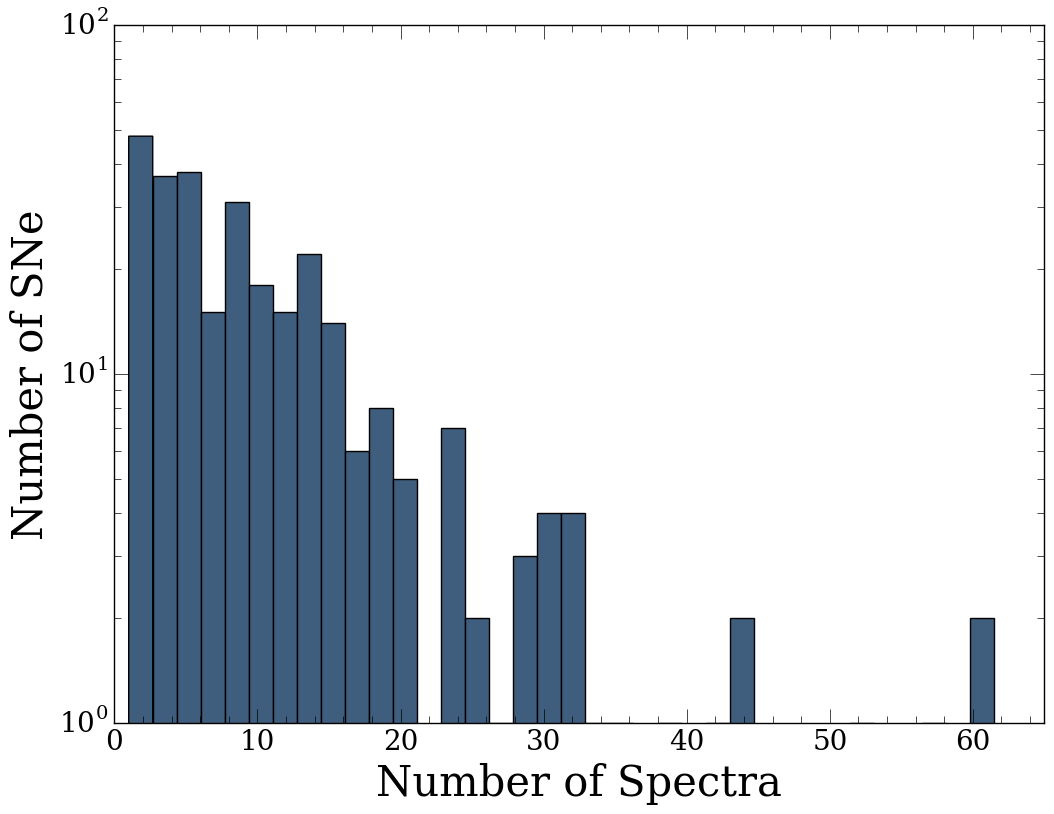

In [32]:
plt.figure(figsize=(12, 9)) 
plt.rc('font', family='serif')
ax = plt.subplot(111)
plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.xlabel("Number of Spectra", fontsize = 30)  
plt.xlim([0,65])
plt.ylabel("Number of SNe", fontsize = 30)  
# plt.hist(spec_per_sn, bins = 50, color="seagreen",log = True)
plt.hist(spec_per_sn_corr, bins = 50, color='#3F5D7D',log = True)
# plt.savefig('../../Paper_Drafts/spec_per_sn.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

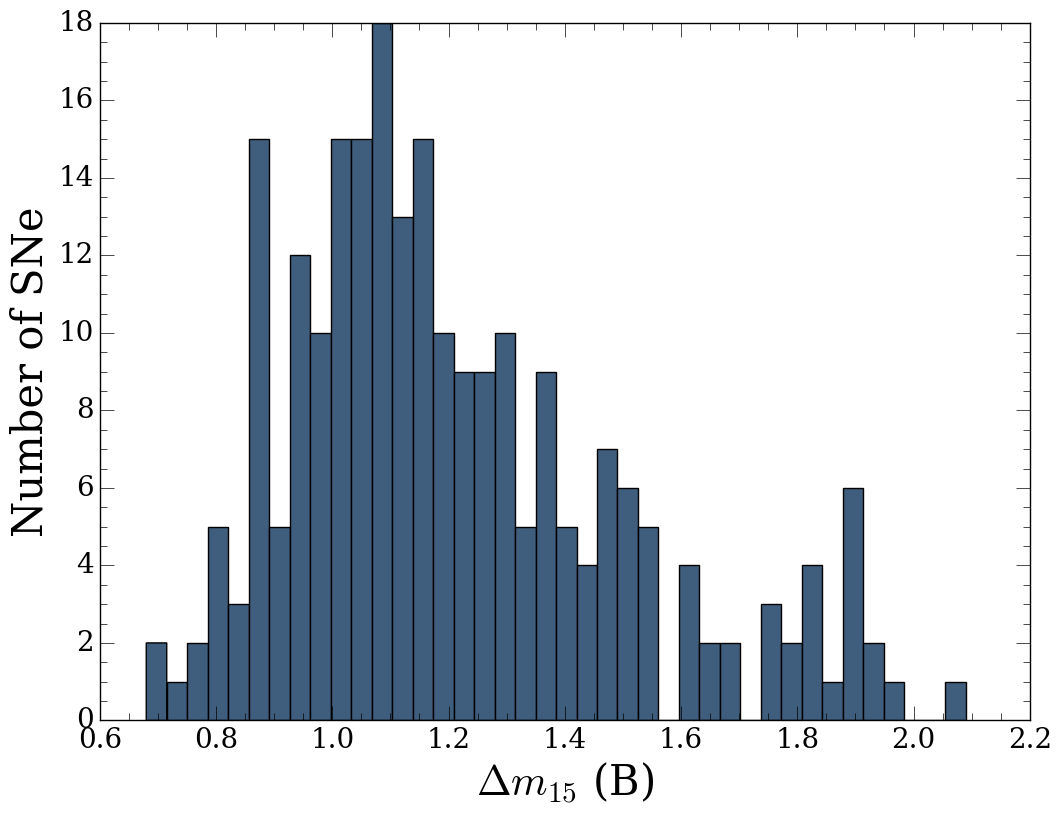

In [33]:
plt.figure(figsize=(12, 9)) 
plt.rc('font', family='serif')
ax = plt.subplot(111)
plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.xlabel("$\Delta m_{15}$ (B)", fontsize=30)  
plt.ylabel("Number of SNe", fontsize=30)  
# plt.hist(dm15_dist, bins = 40, color="seagreen")
plt.hist(dm15_dist_corr, bins = 40, color='#3F5D7D')
# plt.savefig('../../Paper_Drafts/dm15_dist.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

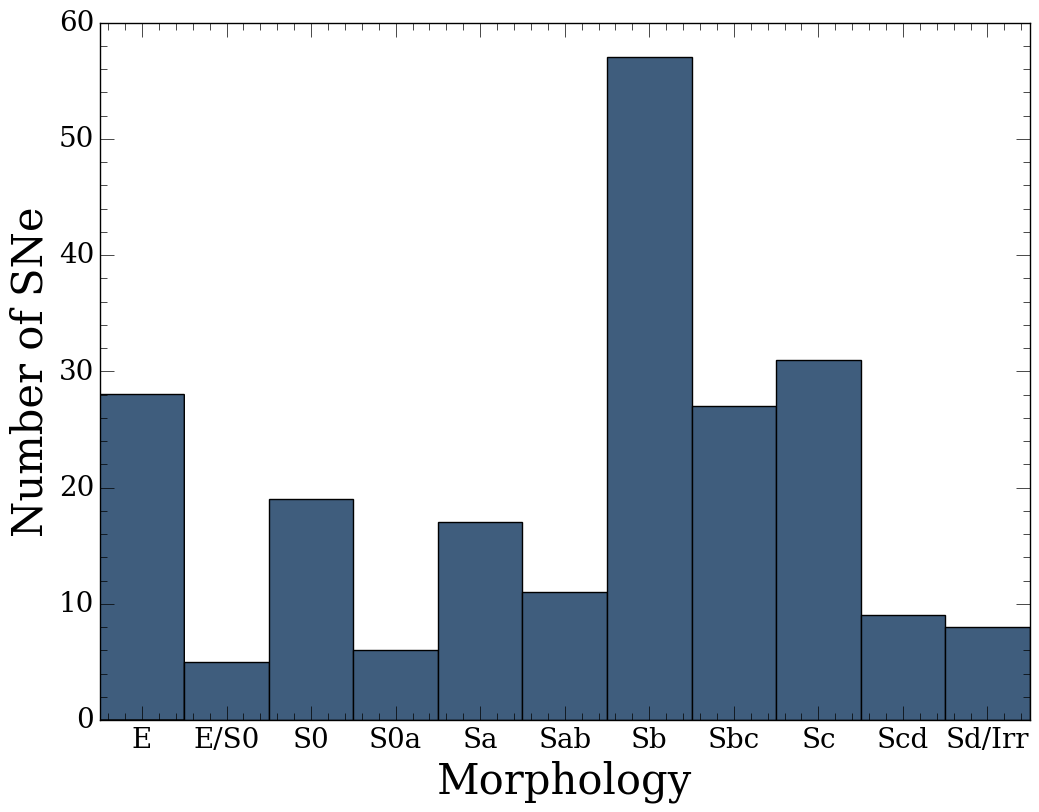

In [34]:
plt.figure(figsize=(12, 9)) 
plt.rc('font', family='serif')
ax = plt.subplot(111)
plt.minorticks_on()
x = [1,2,3,4,5,6,7,8,9,10,11]
labels = ['E','E/S0','S0','S0a','Sa','Sab','Sb','Sbc','Sc','Scd','Sd/Irr']
plt.xticks(x, labels, fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.xlabel("Morphology", fontsize=30)  
plt.ylabel("Number of SNe", fontsize=30)  
# plt.hist(morph_dist,bins=[.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5],  color="seagreen")
plt.hist(morph_dist_corr,bins=[.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5],  color='#3F5D7D')
# plt.savefig('../../Paper_Drafts/morph_dist.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

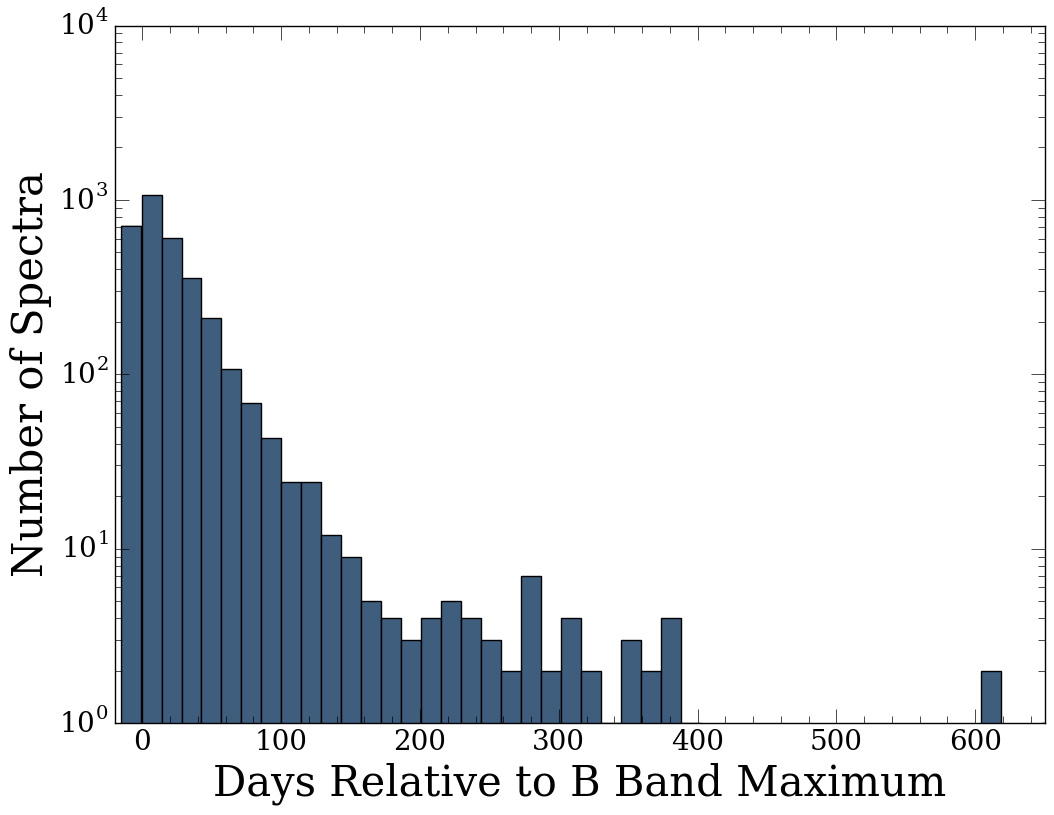

In [35]:
plt.figure(figsize=(12, 9)) 
plt.rc('font', family='serif')
ax = plt.subplot(111)
plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.xlim([-20,650])
plt.ylabel("Number of Spectra", fontsize=30)  
plt.xlabel("Days Relative to B Band Maximum", fontsize=30)  
# plt.hist(phase_dist, bins = 70, color="seagreen", log = True)
plt.hist(phase_dist_corr, bins = 70, color='#3F5D7D', log = True)
# plt.savefig('../../Paper_Drafts/phase_dist.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

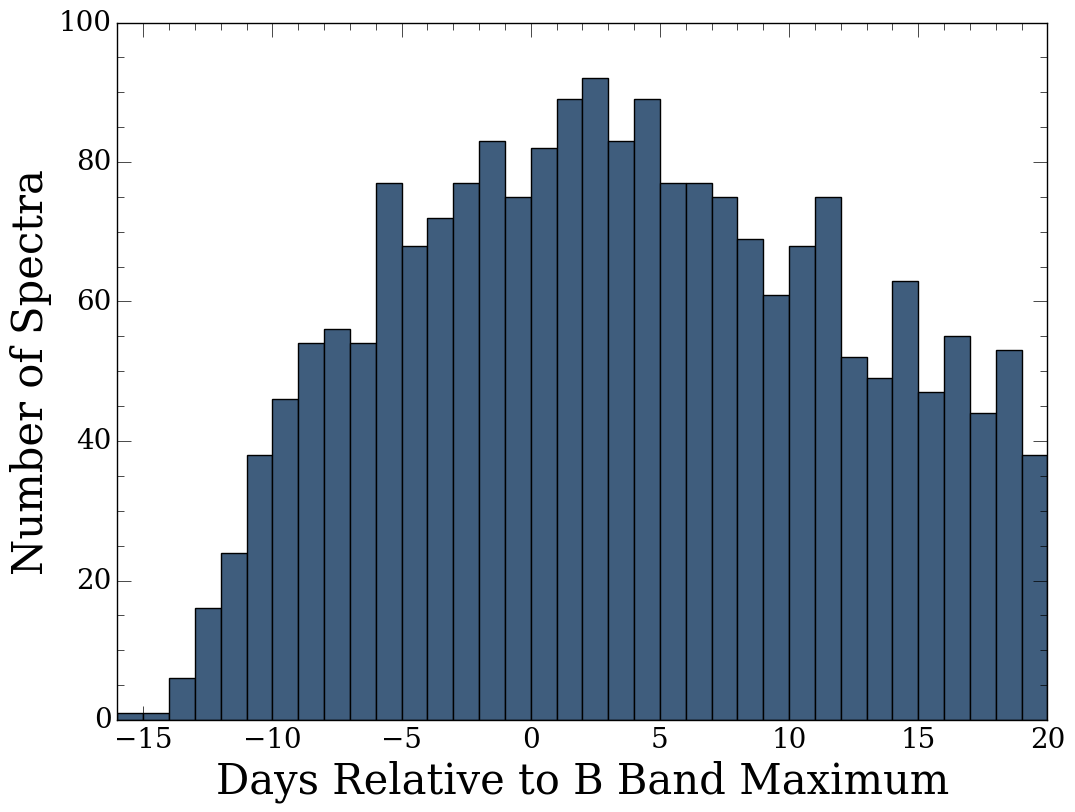

In [48]:
plt.figure(figsize=(12, 9)) 
plt.rc('font', family='serif')
ax = plt.subplot(111)
plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.xlim([-16,20])
plt.xlabel("Days Relative to B Band Maximum", fontsize=30)  
plt.ylabel("Number of Spectra", fontsize=30)  
# plt.hist(phase_dist, bins = 70, color="seagreen", log = True)
plt.hist(phase_dist_corr,bins=range(-20, 20 + 1, 1), color='#3F5D7D')
plt.savefig('../../Paper_Drafts/phase_dist_early.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

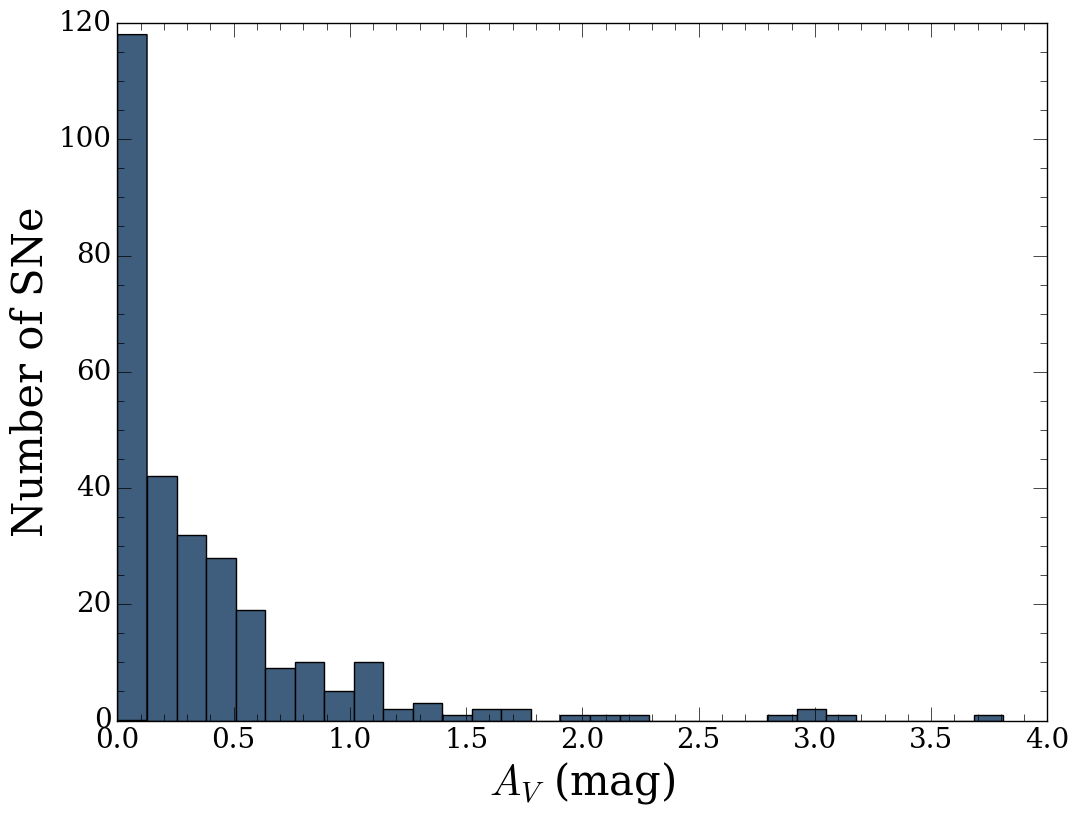

In [38]:
plt.figure(figsize=(12, 9)) 
plt.rc('font', family='serif')
ax = plt.subplot(111)
plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.xlabel("$A_{V}$ (mag)", fontsize=30)  
plt.ylabel("Number of SNe", fontsize=30)  
plt.hist(av_dist,bins=30,  color='#3F5D7D')
# plt.savefig('../../Paper_Drafts/av_dist.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

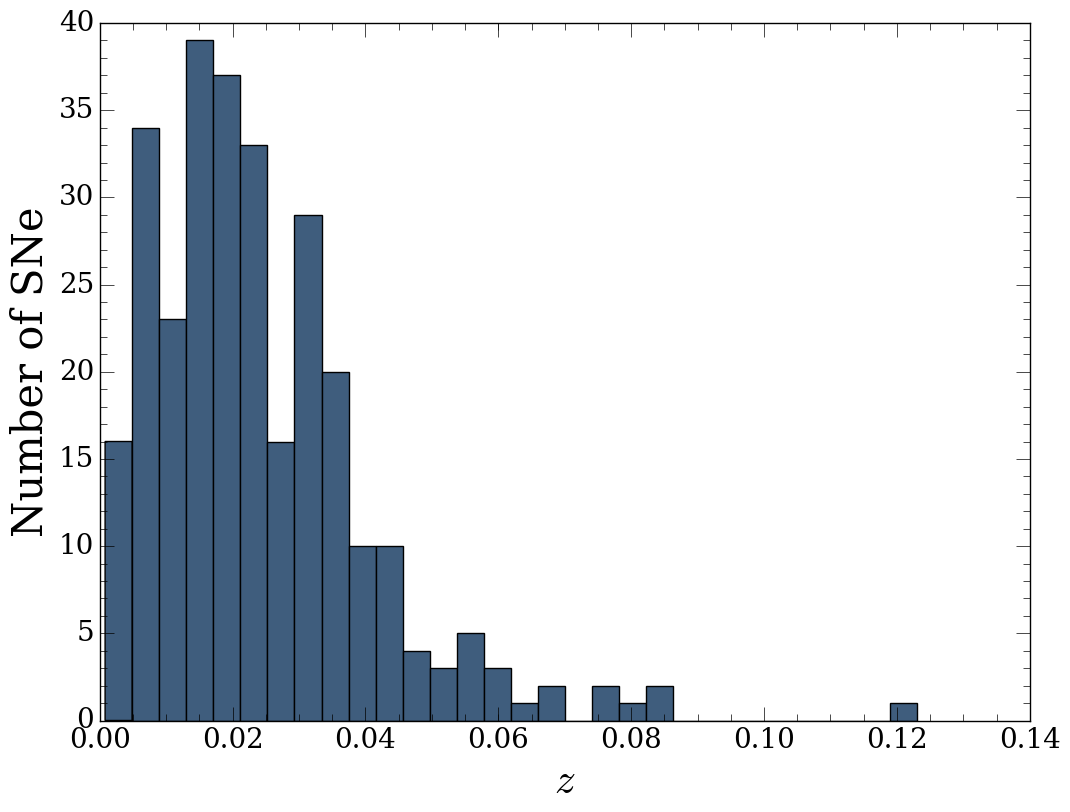

In [39]:
plt.figure(figsize=(12, 9)) 
plt.rc('font', family='serif')
ax = plt.subplot(111)
plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.xlabel("$z$", fontsize=30)  
plt.ylabel("Number of SNe", fontsize=30)  
plt.hist(red_dist_corr,bins=30,  color='#3F5D7D')
# plt.savefig('../../Paper_Drafts/red_dist.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

In [40]:
bsnip,cfa,csp,uv,other = 0, 0, 0, 0, 0
for SN in SN_Array:
    if SN.source == 'bsnip':
        bsnip += 1
    elif SN.source == 'cfa':
        cfa += 1
    elif SN.source == 'csp':
        csp += 1
    elif SN.source == 'uv' or SN.source == 'swift_uv':
        uv +=1
    else:
        other += 1

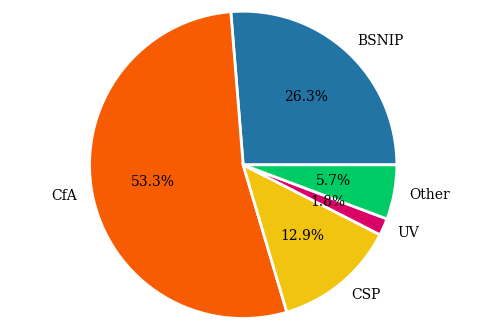

In [41]:
labels = 'BSNIP', 'CfA', 'CSP', 'UV', 'Other'
sizes = [bsnip, cfa, csp, uv, other]
colors = ['#2274A5', '#f75c03', '#f1c40f', '#d90368', '#00cc66']
plt.rc('font', family='serif')
ax = plt.subplot(111) 
wedges, texts, titles = ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors = colors)
for w in wedges:
    w.set_linewidth(2)
    w.set_edgecolor('white')
plt.axis('equal')
# plt.savefig('../../Paper_Drafts/sources.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

In [44]:
bsnip,cfa,csp,uv,other = 0, 0, 0, 0, 0
for SN in event_dict.keys():
    sources = []
    for spectrum in event_dict[SN]:
        sources.append(spectrum.source)
    sources = set(sources)
    for s in sources:
        if s == 'bsnip':
            bsnip += 1
        elif s == 'cfa':
            cfa += 1
        elif s == 'csp':
            csp += 1
        elif s == 'uv' or s == 'swift_uv':
            uv +=1
        else:
            other += 1

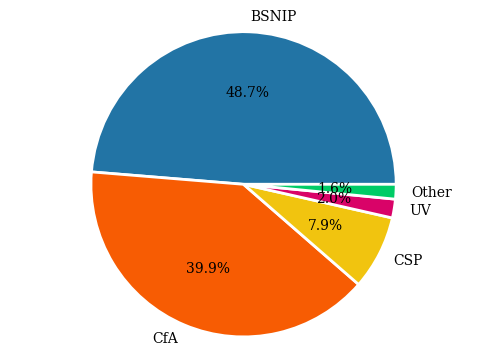

In [49]:
labels = 'BSNIP', 'CfA', 'CSP', 'UV', 'Other'
sizes = [bsnip, cfa, csp, uv, other]
colors = ['#2274A5', '#f75c03', '#f1c40f', '#d90368', '#00cc66']
plt.rc('font', family='serif')
ax = plt.subplot(111) 
wedges, texts, titles = ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors = colors)
for w in wedges:
    w.set_linewidth(2)
    w.set_edgecolor('white')
plt.axis('equal')
plt.savefig('../../Paper_Drafts/event_sources.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

In [51]:
specific_sn_arr = composite.grab("SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where Supernovae.SN = '2005a'", multi_epoch = True, make_corr = False)

5 spectra found
Arrays cleaned


In [57]:
for SN in specific_sn_arr:
    print SN.filename, SN.av_25, SN.source, SN.phase

sn2005a-20050115.357-br.flm 2.9711 bsnip 5.55
sn2005A-20050107.25-fast.flm 2.9711 cfa -2.25
sn2005A-20050108.13-fast.flm 2.9711 cfa -1.37
sn2005A-20050110.11-ldss2.flm 2.9711 cfa 0.610000000001
sn2005A-20050111.04-ldss2.flm 2.9711 cfa 1.54


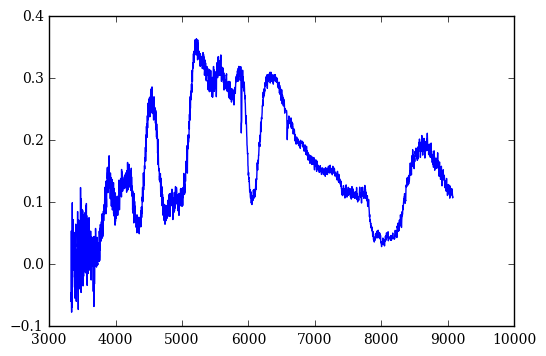

In [56]:
plt.plot(specific_sn_arr[0].wavelength, specific_sn_arr[0].flux)